# Phase Unwrapping

> phase unwrapping

In [ ]:
#| default_exp pu

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import numpy as np
import tempfile
from pathlib import Path
import os
from moraine.gamma_ import read_gamma_pdata, read_gamma_plist, write_gamma_image, write_gamma_plist

from numba import njit
from scipy.spatial import Delaunay
from scipy.sparse import csgraph as csg
import scipy.sparse as sp
from ortools.graph.python import min_cost_flow

In [ ]:
import zarr
import moraine as mr

In [ ]:
#| export
def gamma_mcf_pt(
    pc_x:np.ndarray, # x coordinate, shape of (N,)
    pc_y:np.ndarray, # y coordinate, shape of (N,)
    ph:np.ndarray, # wrapped phase, shape of (N,) or (N,M)
    ph_weight:np.ndarray=None, # point weight, shape of (N,) or (N,M), optional
    ref_point:int=0, # reference point, the first point by default
) -> np.ndarray: # unwrapped phase, shape of (N,) or (N,M)
    '''A simple wrapper for mcf_pt in GAMMA software, only work if you have access to mcf_pt.'''
    pc_x = pc_x.astype(np.int32)
    pc_y = pc_y.astype(np.int32)
    pc_xy = np.stack((pc_x,pc_y),axis=-1)
    ph = ph.astype(np.complex64)

    with tempfile.TemporaryDirectory() as tempdir_str:
        temp_dir = Path(tempdir_str)
        pc_path = temp_dir/'pc'
        ph_path = temp_dir/'ph'
        unwrap_ph_path = temp_dir/'unwrap_ph'
        write_gamma_plist(pc_xy,pc_path)
        write_gamma_image(ph,ph_path)
        if ph_weight is None:
            ph_weight_path = '-'
        else:
            ph_weight_path = temp_dir/'ph_weight'
            ph_wieght = ph_weight.astype(np.float32)
            write_gamma_image(ph_weight,ph_weight_path)
        
        mcf_pt_command = f'mcf_pt {str(pc_path)} - {str(ph_path)} - {str(ph_weight_path)} - {str(unwrap_ph_path)} - - {ref_point} &> {temp_dir/"gamma.log"}'
        os.system(mcf_pt_command)

        unwrap_ph = read_gamma_pdata(unwrap_ph_path,dtype='float')
        unwrap_ph = unwrap_ph.reshape(ph.shape)
    return unwrap_ph

In [ ]:
#| export
def _delaunay(x, y):
    points = np.vstack((x,y)).T
    tri = Delaunay(points,)
    assert tri.coplanar.shape[0] == 0, "input coordinates are not unique."
    return tri.simplices, tri.neighbors

In [ ]:
#| export
def _edge_for_graph_and_dual_graph(simplex, simplex_neighbors):

    # simplex: 0， 1， 2
    # edges: (2, 0), (0, 1), (1, 2)
    edges = np.stack((np.roll(simplex, 1, 1), simplex), axis=2).reshape(-1, 2) # directed
    sort_idx = np.argsort(edges, axis=1)
    sorted_edges = np.take_along_axis(edges, sort_idx, axis=1)
    unique_edges, unique_idx  = np.unique(sorted_edges, axis=0, return_index=True)
    
    num_simplex = simplex.shape[0]
    simplex_edges = np.stack((
        np.broadcast_to(np.arange(num_simplex)[:, None], simplex_neighbors.shape),
        np.roll(simplex_neighbors, -1, 1)), axis=2
    ).reshape(-1, 2) % (num_simplex + 1)
    # this % make -1 become num_simplex, therefore, it connect to the earth simplex

    # simplex_edges: (0,1), (0,2), (0,0)
    # so each simplex_edge exactly match point edge

    unique_simplex_edges = np.take_along_axis(simplex_edges, sort_idx, axis=1)[unique_idx]

    return unique_edges, unique_simplex_edges

In [ ]:
#| export
@njit(fastmath=True)
def _compute_supplys(psi, simplex):
    n_simplex = simplex.shape[0]
    n_vertex = simplex.shape[1]
    two_pi = 2.0 * np.pi

    supplys = np.empty(n_simplex + 1, dtype=np.int32)

    for i in range(n_simplex):
        s = 0.0
        for j in range(n_vertex):
            a = simplex[i, j]
            b = simplex[i, (j - 1) % n_vertex]
            diff = psi[a] - psi[b]
            # wrap to (-pi, pi]
            diff = (diff + np.pi) % two_pi - np.pi
            s += diff
        supplys[i] = int(np.round(s * 0.5 / np.pi))

    # last element: earth node
    supplys[-1] = -np.sum(supplys[:-1])
    return supplys

In [ ]:
#| export
def _solve_mcf_or(simplex_edges, supplys, capacity, weights):
    smcf = min_cost_flow.SimpleMinCostFlow()
    smcf.add_arcs_with_capacity_and_unit_cost(simplex_edges[:,0], simplex_edges[:,1], capacity, weights)
    smcf.add_arcs_with_capacity_and_unit_cost(simplex_edges[:,1], simplex_edges[:,0], capacity, weights)

    smcf.set_nodes_supplies(np.arange(supplys.shape[0]), supplys)
    status = smcf.solve()
    assert status == 1

    n_edge = simplex_edges.shape[0]
    flows = smcf.flows(np.arange(smcf.num_arcs()))
    flows = flows[n_edge:] - flows[:n_edge]
    return flows

In [ ]:
#| export
@njit(fastmath=True, nogil=True)
def _build_adjacency(npts, edges):
    # Count neighbors
    counts = np.zeros(npts, dtype=np.int32)
    for a, b in edges:
        counts[a] += 1
        counts[b] += 1

    indptr = np.empty(npts + 1, dtype=np.int32)
    indptr[0] = 0
    for i in range(npts):
        indptr[i + 1] = indptr[i] + counts[i]

    indices = np.empty(indptr[-1], dtype=np.int32)
    # Precompute edge positions
    edge_pos_a = np.empty(len(edges), dtype=np.int32)
    edge_pos_b = np.empty(len(edges), dtype=np.int32)

    start = indptr.copy()
    for k in range(len(edges)):
        a = edges[k,0]
        b = edges[k,1]

        ia = start[a]
        ib = start[b]

        indices[ia] = b
        indices[ib] = a

        edge_pos_a[k] = ia
        edge_pos_b[k] = ib

        start[a] += 1
        start[b] += 1

    return indptr, indices, edge_pos_a, edge_pos_b

In [ ]:
#| export
@njit(fastmath=True)
def _compute_diff_dual(psi, edges, flows, edge_pos_a, edge_pos_b):
    n_edge = edges.shape[0]
    two_pi = 2.0 * np.pi
    diff_dual = np.empty(n_edge * 2, dtype=psi.dtype)

    for i in range(n_edge):
        a = edges[i, 0]
        b = edges[i, 1]
        diff = psi[b] - psi[a]
        diff = (diff + np.pi) % two_pi - np.pi  # wrap_func
        diff += flows[i] * two_pi
        diff_dual[edge_pos_a[i]] = diff
        diff_dual[edge_pos_b[i]] = -diff

    return diff_dual

In [ ]:
#| export
@njit(fastmath=True, cache=True)
def _unwrap_points_bfs(phase, indptr, indices, gradients):
    """
    BFS-based flood fill using prebuilt CSR adjacency (fast, Numba-compiled).
    """
    npts = len(phase)
    unwrapped = np.zeros(npts, dtype=np.float64)
    visited = np.zeros(npts, dtype=np.bool_)
    visited[0] = True

    queue = [0]
    while queue:
        i = queue.pop(0)
        start, end = indptr[i], indptr[i + 1]
        for idx in range(start, end):
            j = indices[idx]
            g = gradients[idx]
            if not visited[j]:
                unwrapped[j] = unwrapped[i] + g
                visited[j] = True
                queue.append(j)
    return unwrapped + phase[0]

In [ ]:
#| export
def _prepare_mcf(x,y):
    simplex, simplex_neighbors = _delaunay(x,y)
    edges, simplex_edges = _edge_for_graph_and_dual_graph(simplex, simplex_neighbors)
    n_points = x.shape[0]
    indptr, indices, edge_pos_a, edge_pos_b = _build_adjacency(n_points, edges)
    return simplex, edges, simplex_edges, indptr, indices, edge_pos_a, edge_pos_b

In [ ]:
#| export
def _solve_mcf(psi, simplex, edges, simplex_edges, indptr, indices, edge_pos_a, edge_pos_b, capacity=int(1e9), weight=1):
    supplys = _compute_supplys(psi, simplex)
    flows = _solve_mcf_or(simplex_edges, supplys, capacity, weight)
    diff_dual = _compute_diff_dual(psi, edges, flows, edge_pos_a, edge_pos_b)
    unw = _unwrap_points_bfs(psi, indptr, indices, diff_dual)
    return unw

In [ ]:
#| export
def mcf_pc(
    pc_x:np.ndarray, # x coordinate, shape of (N,)
    pc_y:np.ndarray, # y coordinate, shape of (N,)
    ph:np.ndarray, # wrapped phase, shape of (N,), np.complex64
)-> np.ndarray: # unwrapped phase, shape of (N,)
    '''Minimum cost flow phase unwrapping solver.
    Note that the coordinates (pc_x, pc_y) must be unique.
    '''
    # pc_x = pc_x.astype(np.int32)
    # pc_y = pc_y.astype(np.int32)
    psi = np.angle(ph).astype(np.float32)
    required_data = _prepare_mcf(pc_x, pc_y)
    unw = _solve_mcf(psi, *required_data)
    return unw

usage:

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/',mode='r')[:]

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = np.abs(rslc)**2
p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = p < 0.05

# Select DS candidate
shp_num = np.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_gix = np.stack(np.where(is_ds_can),axis=-1)
ds_can_ph, ds_can_emi_quality, ds_can_t_coh = mr.emperical_co_emi_temp_coh_pc(rslc,ds_can_gix,ds_can_is_shp,batch_size=1000)

_is_ds_can_refined = (ds_can_emi_quality>=1.0) & (ds_can_emi_quality <1.2) & (ds_can_t_coh > 0.7) & (ds_can_t_coh <= 1.0)

ds_gix = ds_can_gix[_is_ds_can_refined]
ds_ph = ds_can_ph[_is_ds_can_refined]

ds_hix = mr.pc_hix(ds_gix,shape=rslc.shape[:2])
hix_sort_key = mr.pc_sort(ds_hix)

ds_hix = ds_hix[hix_sort_key]
ds_gix = ds_gix[hix_sort_key]
ds_ph = ds_ph[hix_sort_key]

e = zarr.open('../../data/e.zarr/',mode='r')[:]
n = zarr.open('../../data/n.zarr/',mode='r')[:]

ds_e = mr.ras2pc(e,ds_gix)
ds_n = mr.ras2pc(n,ds_gix)

ds_ph = ds_ph*ds_ph[:,0:1].conj() # set the first image as secondary

Unwrap one interferogram:

In [ ]:
ds_ph_ = ds_ph[:,14]*ds_ph[:,9].conj()
unw = mcf_pc(ds_gix[:,1],ds_gix[:,0], ds_ph_)
unw_gm = gamma_mcf_pt(ds_gix[:,1],ds_gix[:,0], ds_ph_) # if you have access to gamma

# This may produce error as ds_e and ds_n may not be unique
# unw = mcf_pc(ds_e, ds_n, ds_ph_)
# unw_gm = gamma_mcf_pt(ds_e, ds_n, ds_ph_)

In [ ]:
#| hide
def wrap(unw):
    return np.mod(unw + np.pi, 2 * np.pi) - np.pi
np.testing.assert_array_almost_equal(wrap(unw),np.angle(ds_ph_),decimal=3)
# np.testing.assert_array_almost_equal(unw,unw_gm,decimal=3)

In [ ]:
#| hide
# # Unwrap multiple interferograms:
# unw2 = gamma_mcf_pt(ds_e, ds_n, ds_ph[:,2:4])
# np.testing.assert_array_almost_equal(wrap(unw2),np.angle(ds_ph[:,2:4]),decimal=4)

In [ ]:
import holoviews as hv
import numpy as np
from holoviews import opts
from bokeh.models import WheelZoomTool

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
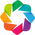

In [ ]:
hv.extension('bokeh')

In [ ]:
unw_plot = mr.pc_plot(unw,ds_n, ds_e)
unw_plot = unw_plot[0]*unw_plot[1]
ph_plot = mr.pc_plot(np.angle(ds_ph_), ds_n, ds_e)
ph_plot = ph_plot[0]*ph_plot[1]

In [ ]:
unw_plot = unw_plot.redim(
    x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'),
    z=hv.Dimension('unw',label='Unwrapped phase')
)
unw_plot.opts(
    opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
               default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
               active_tools=['wheel_zoom']
              ),
    opts.Points(color='unw', cmap='colorwheel',width=600, height=400, colorbar=True,
                default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                active_tools=['wheel_zoom']
               )
)

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [lon,lat]   (Unwrapped phase,idx)
      .Points.I :Points   [lon,lat]   (Unwrapped phase,idx)

In [ ]:
ph_plot = ph_plot.redim(
    x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'),
    z=hv.Dimension('ph',label='Wrapped phase')
)
ph_plot.opts(
    opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
               default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
               active_tools=['wheel_zoom']
              ),
    opts.Points(color='ph', cmap='colorwheel',width=600, height=400, colorbar=True,
                default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                active_tools=['wheel_zoom']
               )
)

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [lon,lat]   (Wrapped phase,idx)
      .Points.I :Points   [lon,lat]   (Wrapped phase,idx)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()